# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

<b> Цель проекта: </b> спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.  

<b> Задача проекта: </b> построить модель с предельно большим значением *F1*-меры (0.59).

Для исследования предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<b> Признаки </b>
- <i>RowNumber</i> — индекс строки в данных
- <i>CustomerId</i> — уникальный идентификатор клиента
- <i>Surname</i> — фамилия
- <i>CreditScore</i> — кредитный рейтинг
- <i>Geography</i> — страна проживания
- <i>Gender</i> — пол
- <i>Age</i> — возраст
- <i>Tenure</i> — сколько лет человек является клиентом банка
- <i>Balance</i> — баланс на счёте
- <i>NumOfProducts</i> — количество продуктов банка, используемых клиентом
- <i>HasCrCard</i> — наличие кредитной карты
- <i>IsActiveMember</i> — активность клиента
- <i>EstimatedSalary</i> — предполагаемая зарплата

<b> Целевой признак </b>
- <i>Exited</i> — факт ухода клиента
    
    
<b> План проекта </b>
    
1. Загрузить и подготовить данные.
2. Исследовать баланс классов, обучить модель без учёта дисбаланса.
3. Улучшить качество модели, учитывая дисбаланс классов. Обучить разные модели и найти лучшую.
4. Финальное тестирование.

## Подготовка данных

### Анализ исходных данных

In [1]:
#загрузим необходимые библиотеки
import os
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Загрузим датасет
pth1 = '/datasets/Churn.csv'
pth2 = 'Churn.csv'

if os.path.exists(pth1):
    df_raw = pd.read_csv(pth1)
    print('platform')
else:
    df_raw = pd.read_csv(pth2)
    print('remote')

remote


In [4]:
#посмотрим на порядок значений в столбцах 
df_raw.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


In [ ]:
'''подробный отчет об исходных данных создан при помощи ProfileReport

profile = ProfileReport(df_raw, title="Pandas Profiling Report")
profile
'''

Количественные данные в целом распределены нормально. Исключением является столбец Balance, где количество околонулевых значений сильно выше. Кроме того, можно выделить несколько этапов для дальнейшей обработки данных:

1. в столбце Tenure есть пропуски, требующие обработки;
2. встречаются столбцы с категориальными данными, которые необходимо преобразовать в количественные;
3. целевой столбец 'Exited' отображает дисбаланс данных, что может помешать обучению;
4. значения в количественных столбцах имеют разный масштаб, который предстоит невелировать.

### Обработка данных

In [6]:
#посмотрим подробнее на таблицу, в столбце с пропусками
df_raw[df_raw['Tenure'].isna()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Похоже, что пропущенные значения не связаны с отсутвием активности или с тем, что клиент отказался от услуг банка. Пропущенные значение могли появиться в связи с ошибкой в выгрузке данных. Удалим данные с пропусками.

In [7]:
# удалим пропуски медианным значением по столбцу и проверим
df_raw.dropna(subset=['Tenure'], inplace = True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        9091 non-null   int64  
 1   CustomerId       9091 non-null   int64  
 2   Surname          9091 non-null   object 
 3   CreditScore      9091 non-null   int64  
 4   Geography        9091 non-null   object 
 5   Gender           9091 non-null   object 
 6   Age              9091 non-null   int64  
 7   Tenure           9091 non-null   float64
 8   Balance          9091 non-null   float64
 9   NumOfProducts    9091 non-null   int64  
 10  HasCrCard        9091 non-null   int64  
 11  IsActiveMember   9091 non-null   int64  
 12  EstimatedSalary  9091 non-null   float64
 13  Exited           9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB


Далее преобразуем категориальные данные в численные, это необходимо для дальнейшей обработкой данных алгоритмом обучения моделей.

In [8]:
# удалим столбцы с порядковыми номерами и именами клиентов, для обучения в этих данных нет необходимости

df = df_raw.drop(['Surname', 'CustomerId', 'RowNumber'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9091 non-null   int64  
 1   Geography        9091 non-null   object 
 2   Gender           9091 non-null   object 
 3   Age              9091 non-null   int64  
 4   Tenure           9091 non-null   float64
 5   Balance          9091 non-null   float64
 6   NumOfProducts    9091 non-null   int64  
 7   HasCrCard        9091 non-null   int64  
 8   IsActiveMember   9091 non-null   int64  
 9   EstimatedSalary  9091 non-null   float64
 10  Exited           9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 852.3+ KB


Geography и Gender имеют также категориальные значения. Выполним преобразование в численные значения. Для столбцов 'Gender' и 'Geography' будем использовать прямое кодирование. 

In [70]:
#определим столбцы для кодирования
categorical = ['Gender', 'Geography']

#определим кодировщик
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder_cols = pd.DataFrame(encoder.fit_transform(df[categorical]))

# вернем индексы, которые удалил кодировщик
encoder_cols.index = df.index

# вернем имена столбцов
encoder_cols.columns = ['Male', 'Female', 'France', 'Spain', 'Germany']

# удалим категориальные столбцы
numeric_df = df.drop(categorical, axis=1)

# объединими данные в новый датафрейм
df_ohe = pd.concat([numeric_df, encoder_cols], axis=1)

df_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Female,France,Spain,Germany
0,619,42,2.0,0.00,1,1,1,101348.88,1,1.0,0.0,1.0,0.0,0.0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1.0,0.0,0.0,0.0,1.0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,1.0,0.0,1.0,0.0,0.0
3,699,39,1.0,0.00,2,0,0,93826.63,0,1.0,0.0,1.0,0.0,0.0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,800,29,2.0,0.00,2,0,0,167773.55,0,1.0,0.0,1.0,0.0,0.0
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0.0,1.0,1.0,0.0,0.0
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0.0,1.0,1.0,0.0,0.0
9997,709,36,7.0,0.00,1,0,1,42085.58,1,1.0,0.0,1.0,0.0,0.0


Данные предварительно обработаны. Удалены пропуски, дублирующиеся по информативности столбцы, категориальные данные преобразованы в числовые. Далее можно посмотреть на корреляцию признаков и целевого столбца.

### Анализ признаков

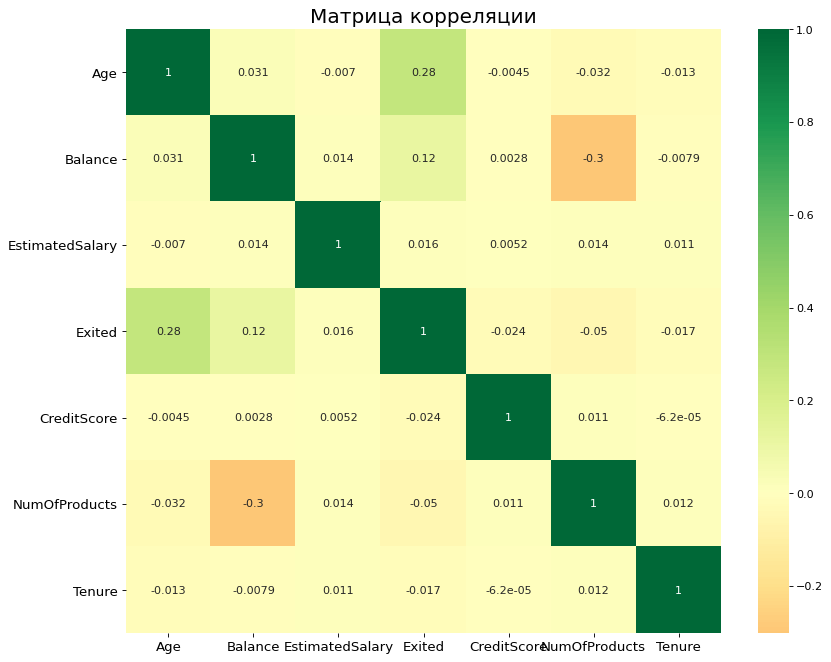

In [10]:
#посмотрим на корреляцию численных признаков друг на друга и на целевой показатель
columns_to_show = ['Age', 'Balance', 'EstimatedSalary', 'Exited', 'CreditScore', 'NumOfProducts', 'Tenure']

plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df[columns_to_show].corr(), xticklabels=df[columns_to_show].corr().columns, 
            yticklabels=df[columns_to_show].corr().columns, 
            cmap='RdYlGn', center=0, annot=True)

#выведем результат
plt.title('Матрица корреляции', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Матрица корреляции показала, что коррелирующих между собой принаков нет. Кроме того, среднее и низкое влияние на целевые показатели 'Existed' оказывают значения в столбцах 'Age' и 'Balance' соотвественно. Далее посмотрим на взаимосвязь признаков между собой и с целевым показателем.

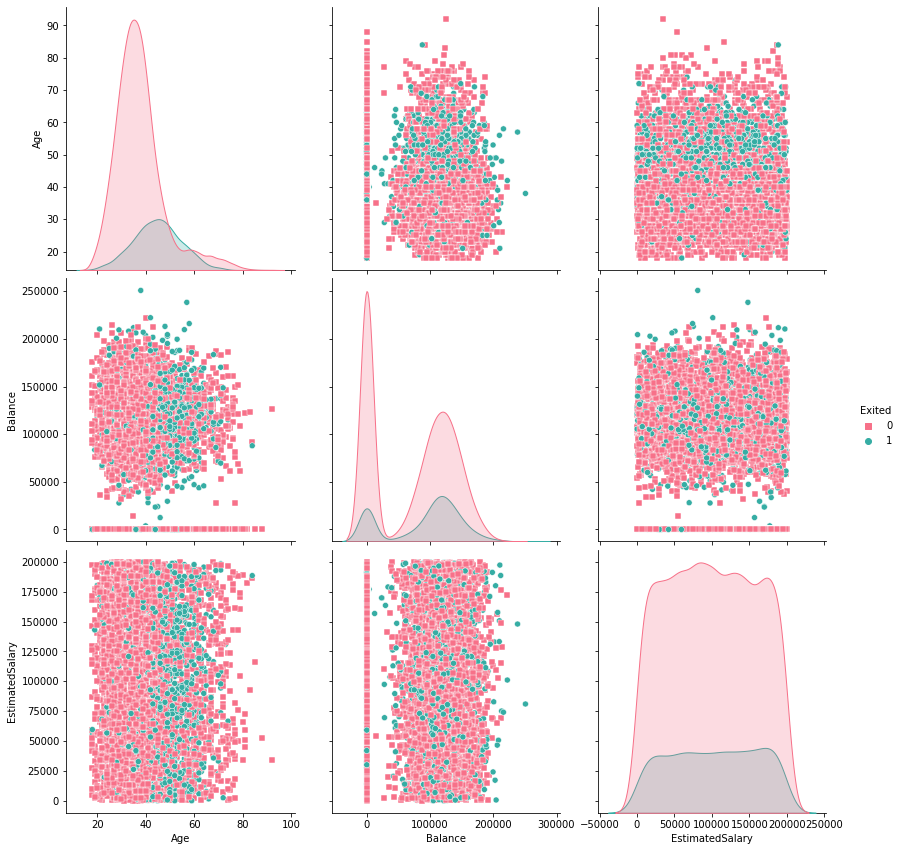

In [11]:
#посмотрим на взаимосвязь выбранных по наличию положительной корреляции параметров для значений целевого столбца
columns_to_show = ['Age', 'Balance', 'EstimatedSalary', 'Exited']

sns.pairplot(df[columns_to_show], hue ='Exited', height=4, markers=['s', 'o'], palette='husl')
plt.show()

Судя по диаграммам распределения можно отметить существенный дисбаланс классов целевого показателя. В остальном, значения признаков распределены равномерно, аномальных значений и зависимостей не замечено. 

## Исследование задачи

Следующим этапом исследуем дисбаланс данных подробнее. Обучим несколько моделей и оценим ключевые: метрики точность и критерий Фишера, для анализа влияния дисбаланса категориальных значений.

In [71]:
#создадим общую выборку с признаками и целевыми значениями
X = df_ohe.drop(['Exited'], axis=1)
y = df_ohe['Exited']


#выделим набор данных для обучающей, валидационной и тестовой выборки в два этапа.
#отделим сначала обучающую выборку, равной 60% от исходных данных
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, shuffle=True, test_size=0.4, stratify=None, random_state=12345)

#далее разделим оставшиеся 40% данных на валидационную и тестовую выборки пополам
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, shuffle=True, test_size=0.5, stratify=None, random_state=12345)


#убедимся, что размер выборок корректен
print(X_train.shape)
print(y_train.shape)
print()
print(X_valid.shape)
print(y_valid.shape)
print()
print(X_test.shape)
print(y_test.shape)

(5454, 13)
(5454,)

(1818, 13)
(1818,)

(1819, 13)
(1819,)


Далее необходимо отмасштабировать некоторые признаки. Колонки 'CreditScore', 'Balance', 'EstimatedSalary' имеют значения гораздо выше, чем другие. Это может помешать при дальнейшем обучении модели, поскольку признакам с большими численными значениями будет присвоен больший вес. Далее стандартизируем численные данные.

In [73]:
#определим столбцы, которые необходимо масштабировать
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

#определим инструмент для масштабирования и обучим на тренировочных данных
scaler = StandardScaler()
scaler.fit(X_train[numeric])

#применим масштабирование для всех выборок
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

0    0.796062
1    0.203938
Name: Exited, dtype: float64


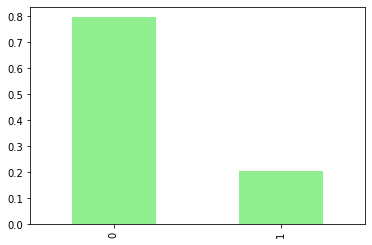

In [74]:
#исследуем баланс классов подробнее

#относительная частота значений от 0 до 1
class_frequency = y.value_counts(normalize=True)

#выведем относительное количество данных в двух классах
print(class_frequency)

#для наглядности выведем диаграмму
class_frequency.plot(kind='bar', color='lightgreen')
None

Таким образом, можно увидеть, что количество действующих клиентов в 4 раза меньше отказавшихся от услуг банка. Это существенный дисбаланс, который может повлиять на качество предсказаний. Далее обучим несколько моделей и проверим, теряется ли точность предсказаний при учете дисбаланса классов.

In [75]:
#обучим модель логистической регрессии и посмотрим точность предсказаний на несбалансированных данных

model_log = LogisticRegression(random_state=12345, solver='liblinear') #объявим модель
model_log.fit(X_train, y_train) #обучим на тренировочной выборке
predicted_valid_log = model_log.predict(X_valid) #получим предсказание на валидационной выборке

# вычислим вероятность положительного класса для всех моделей
prob_valid_l = model_log.predict_proba(X_valid)
#вычислим значение auc_roc
auc_roc_l = roc_auc_score(y_valid, prob_valid_l[:, 1])

print('AUC_ROC:',"%.4f" % auc_roc_l)
print("F1:", "%.4f" % f1_score(y_valid, predicted_valid_log))

AUC_ROC: 0.7736
F1: 0.3034


Критерий Фишера далек от целевого (0.59). Обучим далее модель Дерева решений и Случайный лес, предварительно оптимизировав гиперпараметры.

In [76]:
#Исследуем модель по методу дерева решений

#подберем гиперпараметры для модели дерева решений
clf_t = DecisionTreeClassifier()

parametrs_t = { 'criterion': ['entropy', 'gini'],
              'max_depth': range (1, 17, 2),
              'min_samples_leaf': range (1, 8)}

grid_tree = GridSearchCV(clf_t, parametrs_t, scoring = 'f1', cv=5)
grid_tree.fit(X_train, y_train)
grid_tree.best_params_

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 7}

In [77]:
# обучим модель с заданными гиперпараметрами
model_tree = DecisionTreeClassifier(**grid_tree.best_params_, random_state=12345)

model_tree.fit(X_train, y_train) # обучим модель на тренировочной выборке
predicted_valid_tree = model_tree.predict(X_valid) # получим предсказания модели

# вычислим вероятность положительного класса для всех моделей
prob_valid_t = model_tree.predict_proba(X_valid)
#вычислим значение auc_roc
auc_roc_t = roc_auc_score(y_valid, prob_valid_t[:, 1])

print('AUC_ROC:',"%.4f" % auc_roc_t)
print("F1:", "%.4f" % f1_score(y_valid, predicted_valid_tree))

AUC_ROC: 0.8388
F1: 0.5728


In [18]:
#выберем гиперпараметры для модели случайного дерева

clf_f = RandomForestClassifier()

parametrs_f = { 'n_estimators': range (10, 101, 10),
              'max_depth': range (1, 17, 2),
              'min_samples_leaf': range (1, 8),
              'min_samples_split': range (2, 10, 2) }

grid_forest = GridSearchCV(clf_f, parametrs_f, scoring ='f1', cv=5)
grid_forest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 17, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 101, 10)},
             scoring='f1')

In [49]:
# обучим модель Случайный лес с заданными оптимальными гиперпараметрами
model_forest = RandomForestClassifier(**grid_forest.best_params_, random_state=12345)

model_forest.fit(X_train, y_train) # обучиим модель на тренировочной выборке
predicted_valid_forest = model_forest.predict(X_valid)#получим предсказание

# вычислим вероятность положительного класса для всех моделей
prob_valid_f = model_forest.predict_proba(X_valid)
#вычислим значение auc_roc
auc_roc_f = roc_auc_score(y_valid, prob_valid_f[:, 1])

print('AUC_ROC:',"%.4f" % auc_roc_f)
print("F1:", "%.4f" % f1_score(y_valid, predicted_valid_forest))

AUC_ROC: 0.8681
F1: 0.5763


С учетом дисбаланса данных не удалось достичь целевого значения f1 на валидационной выборке ни для одной модели. Метрика AUC-ROC и критерий f1 выше для модели Случайный лес, худший результат получен на модели Логистическая регрессия. Далее избавимся от дисбаланса данных и сравним метрики.

## Борьба с дисбалансом

### Способ 1 - параметр "class_weight"

Следующим этапом избавимся от дисбаланса в категориях целевого признака и проверим метрики моделей. Сначала попробуем добавить параметр веса "class_weight" для категорий при обучении моделей.

In [53]:
#обучим модель логистической регрессии и посмотрим точность предсказаний параметром веса 'balanced'

#зададим параметры модели
model_log_balanced = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

#обучим на тренировочных данных
model_log_balanced.fit(X_train, y_train)

#получим предсказания для валидационных данных
predicted_valid_log_bal = model_log_balanced.predict(X_valid)

# вычислим вероятность положительного класса для всех моделей
prob_valid_l_bal = model_log_balanced.predict_proba(X_valid)

#вычислим значение auc_roc
auc_roc_l_bal = roc_auc_score(y_valid, prob_valid_l_bal[:, 1])

print('AUC_ROC:',"%.4f" % auc_roc_l_bal)
print("F1:", "%.4f" % f1_score(y_valid, predicted_valid_log_bal))

AUC_ROC: 0.7778
F1: 0.5097


In [52]:
# обучим модель Дерево решений с параметром веса 'balanced'

#зададим модель с оптимальными гиперпараметрами
model_tree_balanced = DecisionTreeClassifier(**grid_tree.best_params_, class_weight='balanced',
                                    random_state=12345)

model_tree_balanced.fit(X_train, y_train) # обучим модель на тренировочной выборке
predicted_valid_tree_bal = model_tree_balanced.predict(X_valid) # получим предсказания модели

# вычислим вероятность положительного класса для всех моделей
prob_valid_t_bal = model_tree_balanced.predict_proba(X_valid)
#вычислим значение auc_roc
auc_roc_t_bal = roc_auc_score(y_valid, prob_valid_t_bal[:, 1])

print('AUC_ROC:',"%.4f" % auc_roc_t_bal)
print("F1:", "%.4f" % f1_score(y_valid, predicted_valid_tree_bal))

AUC_ROC: 0.8400
F1: 0.5690


In [54]:
# обучим модель Случайный лес с параметром веса 'balanced'

#зададим модель с оптимальными гиперпараметрами
model_forest_balanced = RandomForestClassifier(**grid_forest.best_params_, class_weight='balanced',
                                               random_state=12345)

model_forest_balanced.fit(X_train, y_train) # обучиим модель на тренировочной выборке
predicted_valid_forest_bal = model_forest_balanced.predict(X_valid) # получим предсказания модели

# вычислим вероятность положительного класса для всех моделей
prob_valid_f_bal = model_forest_balanced.predict_proba(X_valid)
#вычислим значение auc_roc
auc_roc_f_bal = roc_auc_score(y_valid, prob_valid_f_bal[:, 1])

print('AUC_ROC:',"%.4f" % auc_roc_f_bal)
print("F1:", "%.4f" % f1_score(y_valid, predicted_valid_forest_bal))

AUC_ROC: 0.8693
F1: 0.6408


Метрики auc-roc и f1 стали выше, это говорит о том, что после избавления от дисбаланса полнота и точность предсказаний положительного класса улучшились. Целевой показатель f1 был достигнут для модели Случайный лес.

### Способ 2 - Увеличение выборки

Далее проверим метрики моделей после избавления от дисбаланса данных путем увеличения выборки. Редкий класс будет продублирован, в результате чего дисбаланс невелируется. При этом параметр class_weight='balanced' использоваться не будет.

In [23]:
# создадим новую увеличенную выборку 

def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(
        X_upsampled, y_upsampled, random_state=12345)
    
    return X_upsampled, y_upsampled

X_upsampled, y_upsampled = upsample(X_train, y_train, 4)

#убедимся, что размер выборок корректен
print(y_upsampled.value_counts())

1    4504
0    4328
Name: Exited, dtype: int64


In [55]:
# обучим модель логистической регресси для новой выборки

model_log.fit(X_upsampled, y_upsampled) # обучим модель
predicted_valid_log_up = model_log.predict(X_valid) # получим предсказания на валидационной выборке

# вычислим вероятность положительного класса для всех моделей
prob_valid_l_up = model_log.predict_proba(X_valid)
#вычислим значение auc_roc
auc_roc_l_up = roc_auc_score(y_valid, prob_valid_l_up[:, 1])

print('AUC_ROC:',"%.4f" % auc_roc_l_up)
print("F1:", "%.4f" % f1_score(y_valid, predicted_valid_log_up))

AUC_ROC: 0.7779
F1: 0.5077


In [56]:
# обучим модель Дерева решений для новой выборки

model_tree.fit(X_upsampled, y_upsampled) # обучим модель на новой тренировочной выборке
predicted_valid_tree_up = model_tree.predict(X_valid) # получим предсказания модели

# вычислим вероятность положительного класса для всех моделей
prob_valid_t_up = model_tree.predict_proba(X_valid)
#вычислим значение auc_roc
auc_roc_t_up = roc_auc_score(y_valid, prob_valid_t_up[:, 1])

print('AUC_ROC:',"%.4f" % auc_roc_t_up)
print("F1:", "%.4f" % f1_score(y_valid, predicted_valid_tree_up))

AUC_ROC: 0.8387
F1: 0.5660


In [57]:
# обучим модель Случайный лес для новой выборки

model_forest.fit(X_upsampled, y_upsampled) # обучиим модель на тренировочной выборке
predicted_valid_forest_up = model_forest.predict(X_valid) # получим предсказания модели

# вычислим вероятность положительного класса для всех моделей
prob_valid_f_up = model_forest.predict_proba(X_valid)
#вычислим значение auc_roc
auc_roc_f_up = roc_auc_score(y_valid, prob_valid_f_up[:, 1])

print('AUC_ROC:',"%.4f" % auc_roc_f_up)
print("F1:", "%.4f" % f1_score(y_valid, predicted_valid_forest_up))

AUC_ROC: 0.8669
F1: 0.6312


Ключевые метрики оказались ниже при данном подходе, но лучше, чем при учете дисбаланса классов. Лучшие результаты также показал алгоритм обучения Случайный лес.

### Способ 3 - Уменьшение выборки

Далее проверим следущий способ - борьба с дисбалансом путем уменьшения выборки. Количество данных для самого частого класса будет сокращено, что способствует невелированию дисбаланса.

In [27]:
# создадим новую уменьшенную выборку

def downsample(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=12345)] + [X_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=12345)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(
        X_downsampled, y_downsampled, random_state=12345)
    
    return X_downsampled, y_downsampled

X_downsampled, y_downsampled = downsample(X_train, y_train, 0.4)

#убедимся, что размер выборок корректен
print(y_upsampled.value_counts())

1    4504
0    4328
Name: Exited, dtype: int64


In [59]:
# обучим модель Логистической регресси для новой выборки

model_log.fit(X_downsampled, y_downsampled) # обучиим модель на тренировочной выборке
predicted_valid_log_down = model_log.predict(X_valid) # получим предсказания модели

# вычислим вероятность положительного класса для всех моделей
prob_valid_l_down = model_log.predict_proba(X_valid)
#вычислим значение auc_roc
auc_roc_l_down = roc_auc_score(y_valid, prob_valid_l_down[:, 1])

print('AUC_ROC:',"%.4f" % auc_roc_l_down)
print("F1:", "%.4f" % f1_score(y_valid, predicted_valid_log_down))

AUC_ROC: 0.7714
F1: 0.4982


In [60]:
# обучим модель Дерева решений для новой выборки

model_tree.fit(X_downsampled, y_downsampled) # обучим модель на тренировочной выборке
predicted_valid_tree_down = model_tree.predict(X_valid) # получим предсказания модели

# вычислим вероятность положительного класса для всех моделей
prob_valid_t_down = model_tree.predict_proba(X_valid)
#вычислим значение auc_roc
auc_roc_t_down = roc_auc_score(y_valid, prob_valid_t_down[:, 1])

print('AUC_ROC:',"%.4f" % auc_roc_t_down)
print("F1:", "%.4f" % f1_score(y_valid, predicted_valid_tree_down))

AUC_ROC: 0.8372
F1: 0.5827


In [62]:
# обучим модель Случайный лес для новой выборки

model_forest.fit(X_downsampled, y_downsampled) # обучиим модель на тренировочной выборке
predicted_valid_forest_down = model_forest.predict(X_valid) # получим предсказания модели

# вычислим вероятность положительного класса для всех моделей
prob_valid_f_down = model_forest.predict_proba(X_valid)
#вычислим значение auc_roc
auc_roc_f_down = roc_auc_score(y_valid, prob_valid_f_down[:, 1])

print('AUC_ROC:',"%.4f" % auc_roc_f_down)
print("F1:", "%.4f" % f1_score(y_valid, predicted_valid_forest_down))

AUC_ROC: 0.8662
F1: 0.6163


После исследования нескольких спосбов для борьбы с дисбалансом целевых категориальных данных можно сделать несколько выводов:
1. Для текущей задачи наиболее эффективным получился метод добавления параметра class_weight='balanced' при обучении моделей:
   - Логистическая регрессия (auc_roc - 0.78, f1 - 0.51);
   - Дерево решений (auc_roc - 0.84, f1 - 0.57);
   - Случайный лес (auc_roc - 0.87, f1 - 0.64).
2.Увеличение выборки оказалось более эффективным в борьбе с дисбалансом, чем уменьшение выборки.
3. Модель Дерево решений показало низкую чувствительность к изменению баланса категорий. 
4. Лучший показатель f1 достигнут для модели Случайный лес. 

Далее проанализируем основные метрики, отвечающие за точность предсказаний и качество для модели Случайный лес с оптимизированными гиперпараметрами и с сбалансированными данными. 

### Анализ метрик классификации

Проверим, как меняется матрица ошибок на сбалансированных и не сбалансированных данных.

In [31]:
# выведем матрицу ошибок для выборанной модели Случайный Лес для сбалансированных данных

conf_matrix_balanced = pd.DataFrame(confusion_matrix(y_valid, predicted_valid_forest_bal), 
                           index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
conf_matrix_balanced

,predicted 0,predicted 1
actual 0,1362,79
actual 1,162,215


In [78]:
# выведем матрицу ошибок для выборанной модели Случайный Лес на несбалансированных данных
conf_matrix = pd.DataFrame(confusion_matrix(y_valid, predicted_valid_forest), 
                           index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,1398,43
actual 1,207,170


В имеющихся данных дисбаланс заключается в том, что категория с значениями 1 гораздо меньше категории 0. Сравнение матриц ошибок для сбалансированной и несбалансированной выборок показывает, что количество верных предсказаний категории для 1 увеличислось, а количество ошибок сократилось. По итогу можно сделать вывод, что борьба с дисбалансом способстовала в целом улучшению качества предсказаний.

Далее дополнительно проверим качество моделей для нескольких метриках - PR-кривой и значению ROC-AUC. Для анализа будут использованны модели, обученные путем реализации первого способа борьбы с дисбалансом данных.

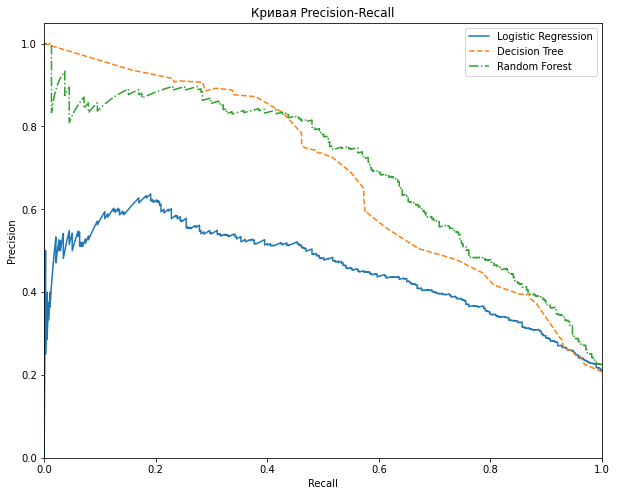

In [33]:
# посмотрим на изменение метрик полноты и точности при изменении порога классификации для всех моделей

# вычислим вероятность положительного класса для всех моделей
probabilities_valid_forest = model_forest_balanced.predict_proba(X_valid) # Случайный лес
probabilities_valid_tree = model_tree_balanced.predict_proba(X_valid) # Дерево решений
probabilities_valid_log = model_log_balanced.predict_proba(X_valid) # Логистическая регрессия

# вычислим значения точности, полноты и порога для всех моделей
precision_f, recall_f, thresholds_f = precision_recall_curve(y_valid, 
                                                             probabilities_valid_forest[:, 1]) # Случайный лес
precision_t, recall_t, thresholds_t = precision_recall_curve(y_valid, 
                                                             probabilities_valid_tree[:, 1]) # Дерево решений
precision_l, recall_l, thresholds_l = precision_recall_curve(y_valid, 
                                                             probabilities_valid_log[:, 1]) # Логистическая регрессия

# выведем графики изменения кривых по мере изменения порога 
plt.figure(figsize=(10, 8))
plt.plot(recall_l, precision_l, linestyle='-', label='Logistic Regression')
plt.plot(recall_t, precision_t, linestyle='--', label='Decision Tree')
plt.plot(recall_f, precision_f, linestyle='-.', label='Random Forest')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

Выше кривая для результатов модели Случайный лес. Худшие результаты для данной задачи показала модель Логистическая регрессия.

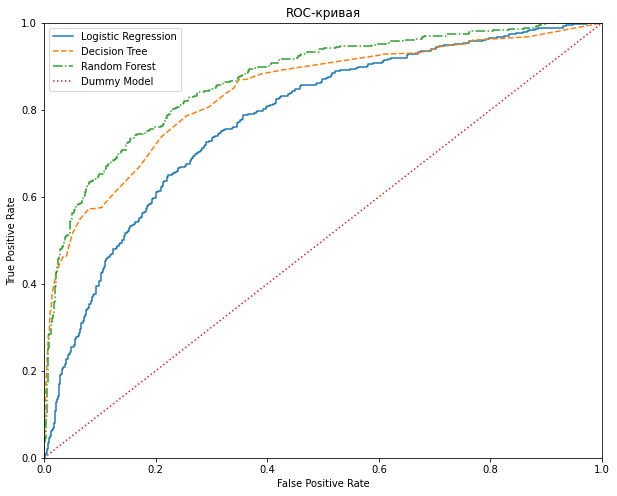

In [34]:
# посмотрим на кривую ошибок при изменении порога классификации для всех моделей

# вычислим значения ошибок и порога для всех моделей
fpr_f, tpr_f, thresholds_f = roc_curve(y_valid, probabilities_valid_forest[:, 1]) # Случайный лес
fpr_t, tpr_t, thresholds_t = roc_curve(y_valid, probabilities_valid_tree[:, 1]) # Дерево решений
fpr_l, tpr_l, thresholds_l = roc_curve(y_valid, probabilities_valid_log[:, 1]) # Логистическая регрессия

# выведем графики кривой ошибок для всех моделей
plt.figure(figsize=(10, 8))
plt.plot(fpr_l, tpr_l, linestyle='-', label='Logistic Regression')
plt.plot(fpr_t, tpr_t, linestyle='--', label='Decision Tree')
plt.plot(fpr_f, tpr_f, linestyle='-.', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle=':', label='Dummy Model') # добавим график для случаной модели
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая')
plt.show()

In [35]:
# также выведем численные значения площадей для каждой кривой

auc_roc_l = roc_auc_score(y_valid, probabilities_valid_log[:, 1]) # Логистическая регрессия
auc_roc_t = roc_auc_score(y_valid, probabilities_valid_tree[:, 1]) # Дерево решений
auc_roc_f = roc_auc_score(y_valid, probabilities_valid_forest[:, 1]) # Случайный лес

print('Логистическая регрессия AUC_ROC:',"%.4f" % auc_roc_l)
print('Дерево решений AUC_ROC:', "%.4f" %  auc_roc_t)
print('Случайный лес AUC_ROC:', "%.4f" %  auc_roc_f)

Логистическая регрессия AUC_ROC: 0.7778
Дерево решений AUC_ROC: 0.8400
Случайный лес AUC_ROC: 0.8693


ROC- кривые показывают отношение ложноположительных ответов (FPR) и истинно положительных ответов (TPR) по мере изменения порога классификации. Для оценки качества модели используется площадь под соотвествующей кривой - метрика AUC-ROC. Судя по характеру кривой ошибок и площади под кривой, качество предсказаний выше для модели Случайный лес. 

## Тестирование модели

Модель Случайный лес показала лучшее качество по основным метрикам. Далее проведем ее тестирование.

In [64]:
# получим точность и критерий Фишера для тестовой выборки
predicted_valid_forest_test = model_forest_balanced.predict(X_test)

# вычислим вероятность положительного класса для всех моделей
probabilities_test = model_forest_balanced.predict_proba(X_test)
#вычислим значение auc_roc
auc_roc_test = roc_auc_score(y_test, probabilities_test[:, 1])

print('AUC_ROC:',"%.4f" % auc_roc_test)
print("F1:", "%.4f" % f1_score(y_test, predicted_valid_forest_test))

AUC_ROC: 0.8523
F1: 0.6109


In [66]:
# выведем матрицу ошибок
conf_matrix = pd.DataFrame(confusion_matrix(y_test, predicted_valid_forest_test), 
                           index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,1362,106
actual 1,150,201


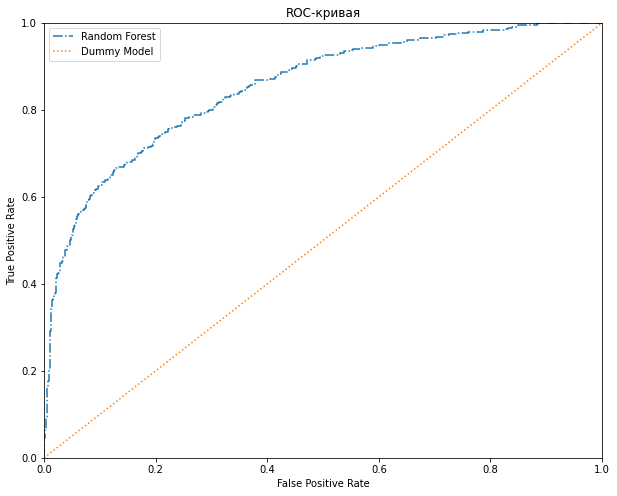

In [68]:
# получим кривую ошибок для тестовых данных
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probabilities_test[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, linestyle='-.', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle=':', label='Dummy Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая')
plt.show()

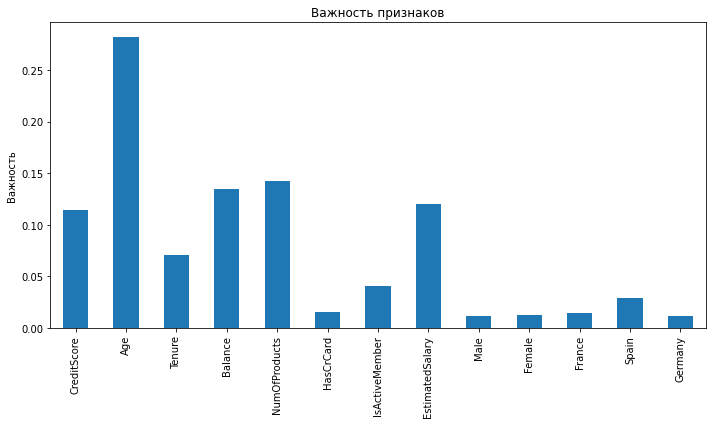

In [79]:
#Выведем диаграмму с оценкой влияния признаков на целевой
imp = pd.Series(model_forest_balanced.feature_importances_,
               X_test.columns)

fig, ax = plt.subplots(figsize=(10,6))
imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Метрика f1 превысила заданное пороговое значени (0.59). Матрица ошибок показала допустимый результат точности предсказаний для имеющихся классов. Кривая ошибок получилась гораздо выше кривой для случайной модели, как и значение площади auc-roc. Кроме того определено, что наибольшее влияние на целевой показатель оказвают признаки 'Age', 'NumOfProducts' и 'Balance'.

## Итоговые выводы

В результате исследования была решена задача построения модели с предельно большим значением *F1*-меры (0.59). Наилучшие результаты показала модель Случайный лес с оптимизированными гиперпараметрами и устраненным дисбалансом данных, достигнутым при обучении модели путем установки параметра class_weight='balanced'. 

Основные метрики итоговой модели, полученных в ходе финального тестирования:
- F1 - 0.61;
- AUC-ROC - 0.85.

Таким образом, достигнута цель по качественному определению того, уйдёт клиент из банка в ближайшее время или нет.

В ходе проекта выполнены следующие этапы и получены промежуточные результаты:
    
1. Загружены и подготовлены данные:
   - заполены пропуски, удалены дублирующиеся по информативности столбцы; 
   - категориальные данные преобразованы в числовые;
   - численные значения отмасштабированы; 
   - исследована корреляция признаков и целевого столбца.
2. Исследован баланс классов, обучены модели без учёта дисбаланса и получены результаты:
   - Логистическая регрессия - auc_roc - 0.78, f1 - 0.30;
   - Дерево решений - auc_roc - 0.84, f1 - 0.57;
   - Случайный лес - auc_roc - 0.87, f1 - 0.58;
3. Дисбаланс классов учтен несколькими способами и получены результаты:
   - Способ 1 - параметр "class_weight":
      - Логистическая регрессия - auc_roc - 0.78, f1 - 0.51;
      - Дерево решений - auc_roc - 0.84, f1 - 0.57;
      - Случайный лес - auc_roc - 0.87, f1 - 0.64;
   - Способ 2 - Увеличение выборки:
      - Логистическая регрессия - auc_roc - 0.78, f1 - 0.51;
      - Дерево решений - auc_roc - 0.84, f1 - 0.57;
      - Случайный лес - auc_roc - 0.87, f1 - 0.63;
   - Способ 3 - Уменьшение выборки:
      - Логистическая регрессия - auc_roc - 0.77, f1 - 0.50;
      - Дерево решений - auc_roc - 0.84, f1 - 0.58;
      - Случайный лес - auc_roc - 0.87, f1 - 0.61;
4. Проведено финальное тестирование на модели Случайный лес с оптимизированными гиперпараметрами и устраненным дисбалансом данных, достигнутым при обучении модели путем установки параметра class_weight='balanced'
5. Наибольшее влияние на целевой показатель оказвают признаки 'Age', 'NumOfProducts' и 'Balance'